# Test PDPbox with Regression problem
## Kaggle Rossmann store with RandomForest regressor
This demo is based on **Rossmann Store Sales**  
https://www.kaggle.com/c/otto-group-product-classification-challenge

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../')

from pdpbox import pdp, get_dataset

## get dataset

In [3]:
test_ross = get_dataset.ross()
test_ross.keys()

['data', 'features', 'rf_model', 'target']

In [4]:
ross_data = test_ross['data']
ross_features = test_ross['features']
ross_model = test_ross['rf_model']
ross_target = test_ross['target']

## binary feature: SchoolHoliday

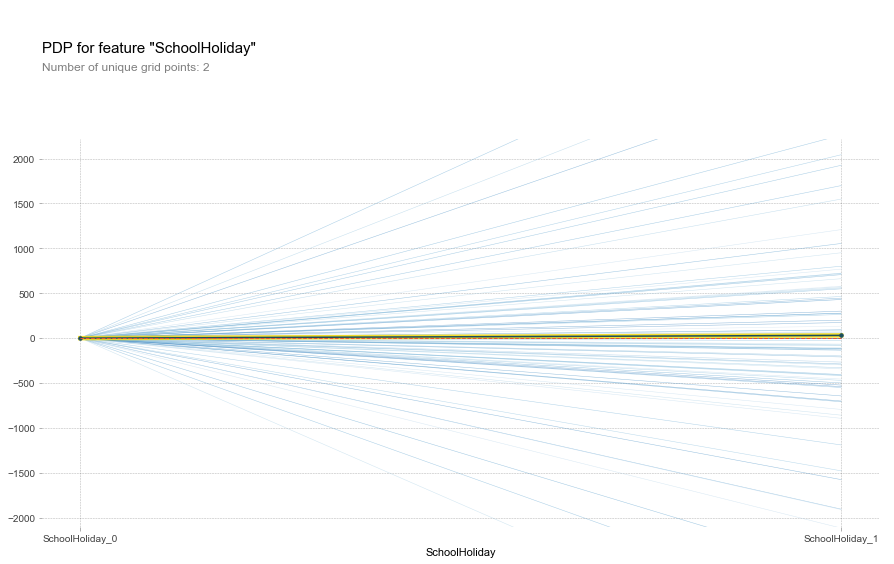

In [5]:
pdp_SchoolHoliday = pdp.pdp_isolate(ross_model, ross_data[ross_features], 'SchoolHoliday')
fig, axes = pdp.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_lines=True, frac_to_plot=100)

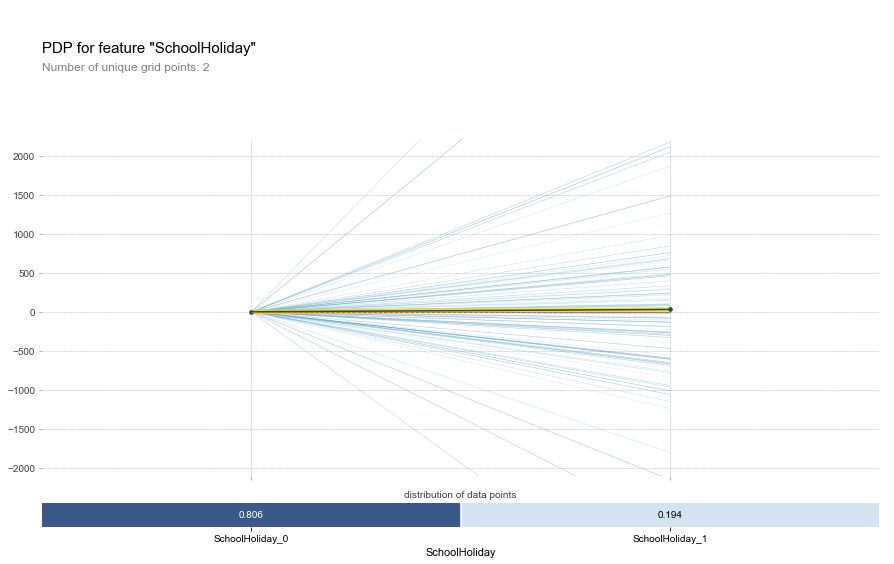

In [6]:
fig, axes = pdp.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

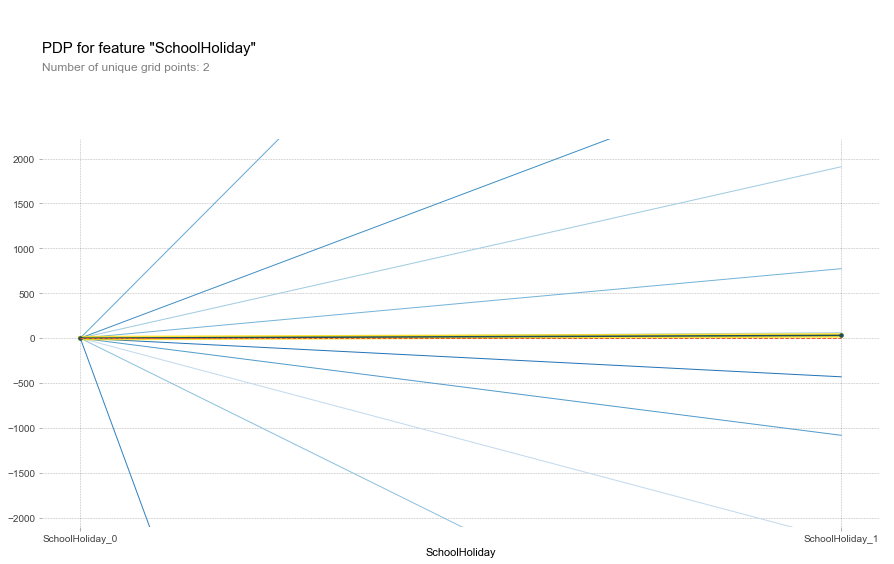

In [7]:
# cluster the individual lines
fig, axes = pdp.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_lines=True, frac_to_plot=100, cluster=True, 
                         n_cluster_centers=10, cluster_method='accurate')

## onehot encoding feature: StoreType

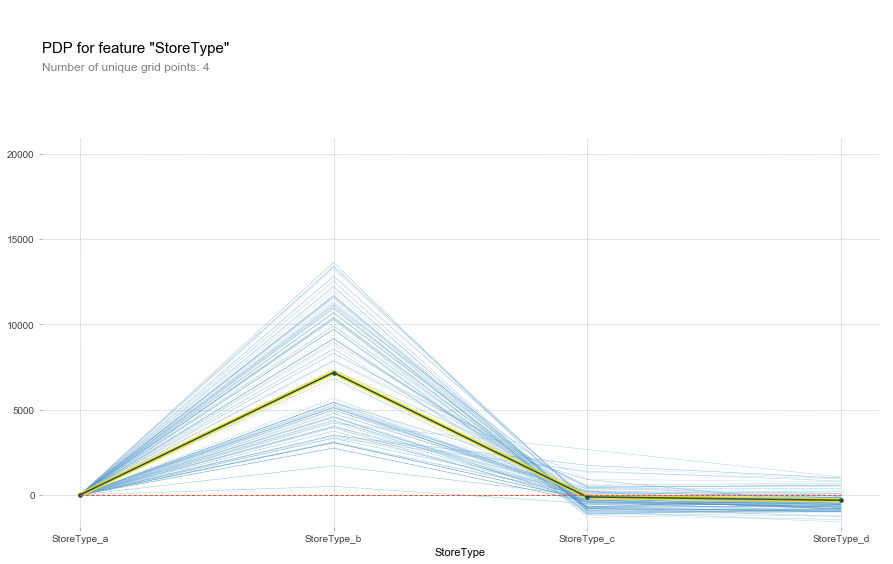

In [11]:
pdp_StoreType = pdp.pdp_isolate(ross_model, ross_data[ross_features], 
                                ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'])
fig, axes = pdp.pdp_plot(pdp_StoreType, 'StoreType', plot_lines=True, frac_to_plot=100)

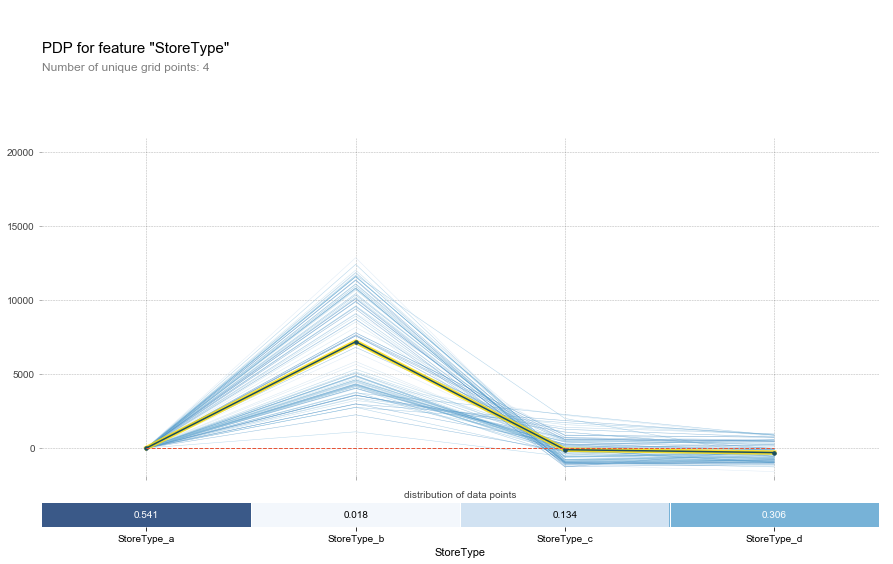

In [12]:
fig, axes = pdp.pdp_plot(pdp_StoreType, 'StoreType', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

## numeric feature: weekofyear

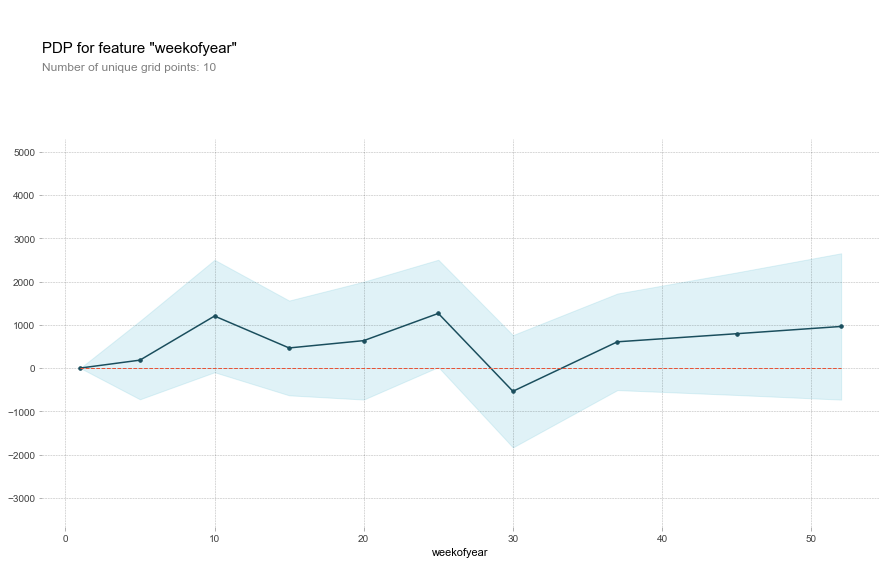

In [5]:
pdp_weekofyear = pdp.pdp_isolate(ross_model, ross_data[ross_features], 'weekofyear', n_jobs=2)
fig, axes = pdp.pdp_plot(pdp_weekofyear, 'weekofyear')

(<matplotlib.figure.Figure at 0x22dd3a20>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13ae47b8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x22f24b38>})

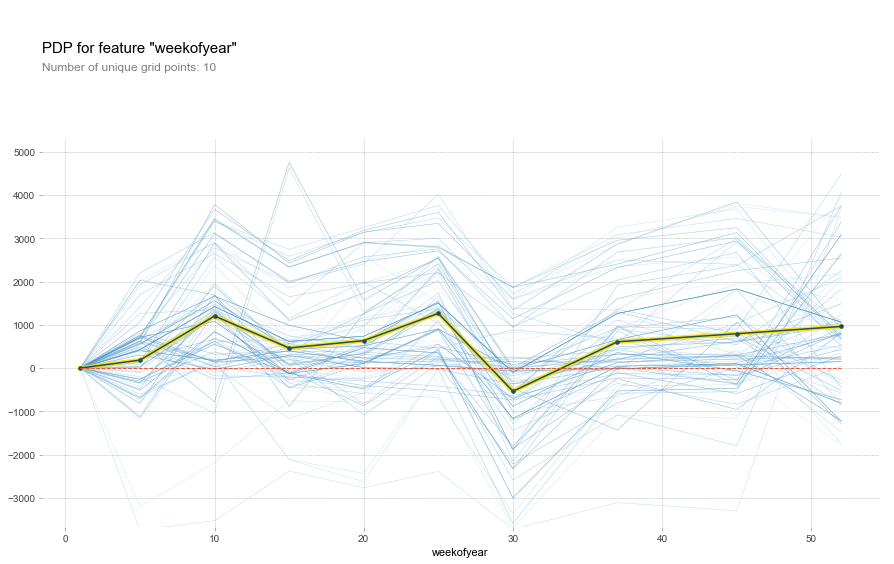

In [14]:
pdp.pdp_plot(pdp_weekofyear, 'weekofyear', plot_lines=True, frac_to_plot=100)

(<matplotlib.figure.Figure at 0x238cb898>,
 {'pdp_ax': {'_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x22af3978>,
   '_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x20b2fcf8>},
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x22615e10>})

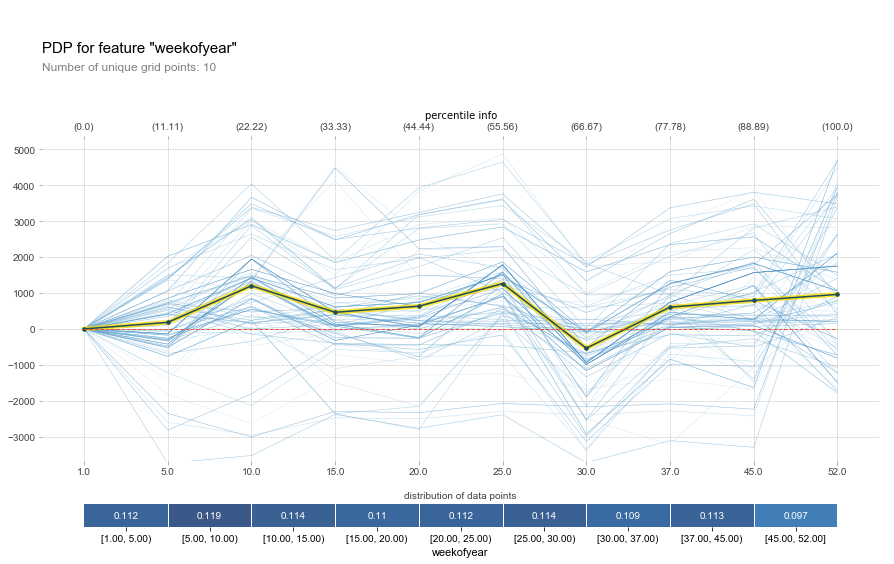

In [17]:
pdp.pdp_plot(pdp_weekofyear, 'weekofyear', plot_lines=True, frac_to_plot=100, x_quantile=True, 
             plot_pts_dist=True, show_percentile=True)

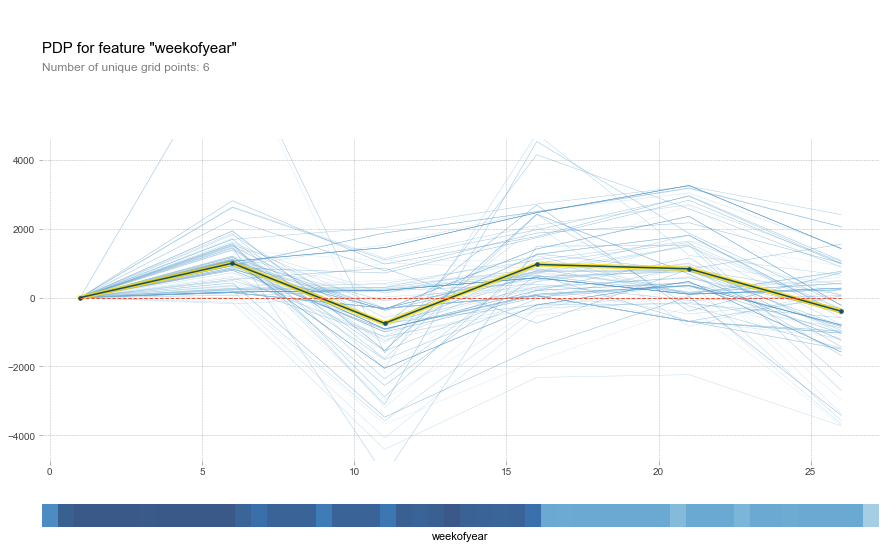

In [6]:
pdp_weekofyear = pdp.pdp_isolate(ross_model, ross_data[ross_features], 'weekofyear', cust_grid_points=range(1, 30, 5))
fig, axes = pdp.pdp_plot(pdp_weekofyear, 'weekofyear', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

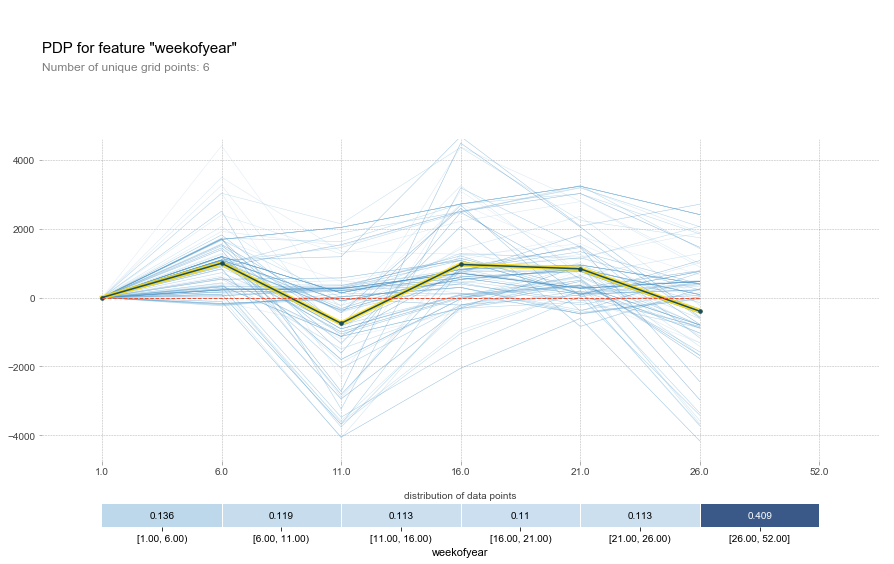

In [19]:
fig, axes = pdp.pdp_plot(pdp_weekofyear, 'weekofyear', plot_lines=True, frac_to_plot=100, plot_pts_dist=True, x_quantile=True)

## test interaction

In [5]:
%%time
inter_rf = pdp.pdp_interact(ross_model, ross_data[ross_features], 
                            ['weekofyear', ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']], 
                            num_grid_points=[10, 10], n_jobs=6)

CPU times: user 16.5 s, sys: 8.15 s, total: 24.6 s
Wall time: 55.5 s


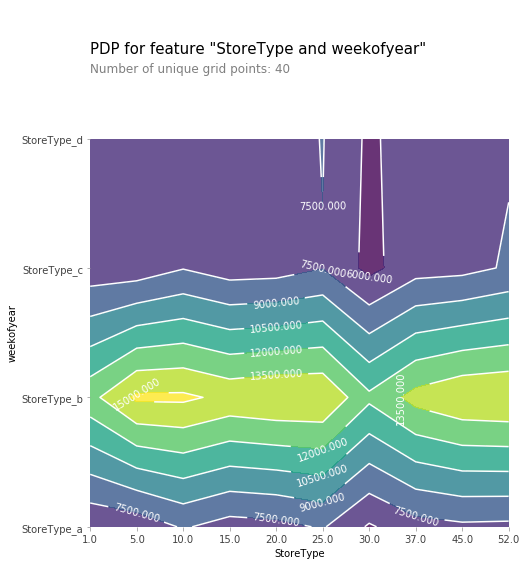

In [6]:
fig, axes = pdp.pdp_interact_plot(inter_rf, ['StoreType', 'weekofyear'], x_quantile=True, 
                                  plot_type='contour', plot_pdp=False)

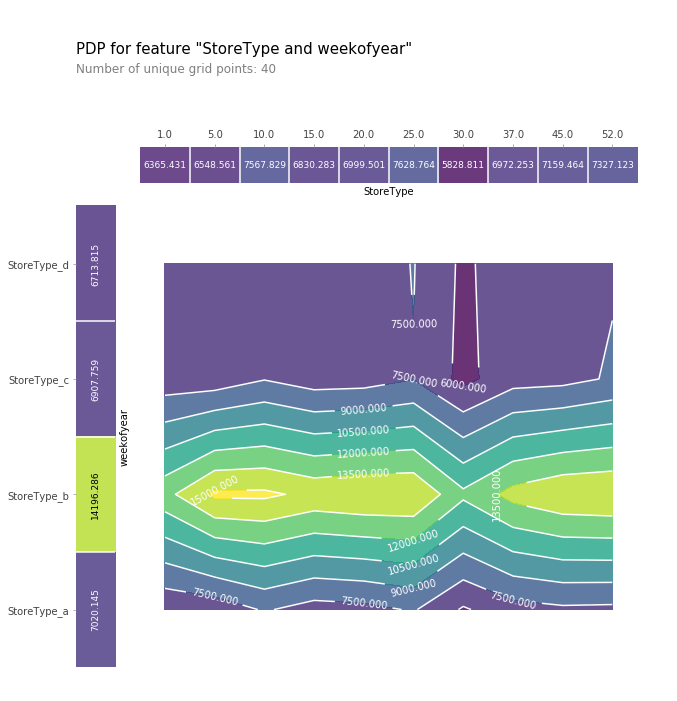

In [7]:
fig, axes = pdp.pdp_interact_plot(inter_rf, ['StoreType', 'weekofyear'], x_quantile=True, 
                                  plot_type='contour', plot_pdp=True)

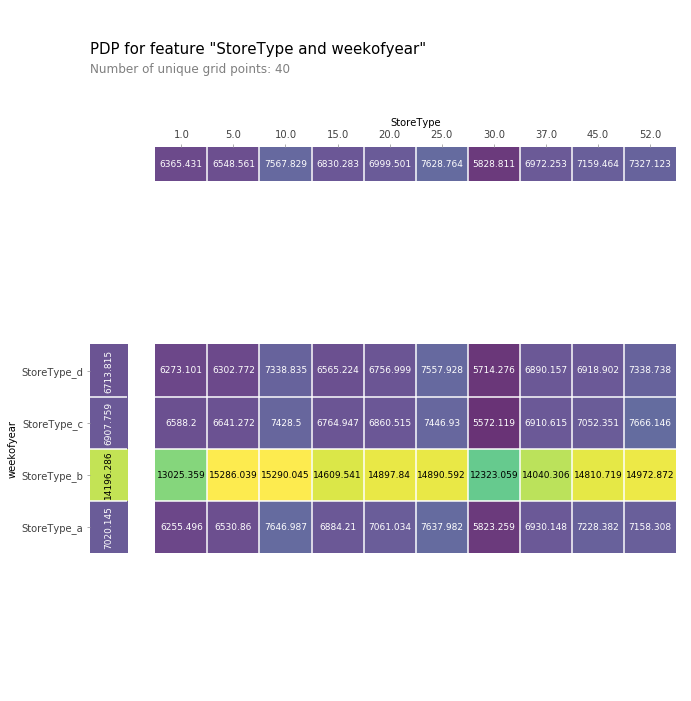

In [8]:
fig, axes = pdp.pdp_interact_plot(inter_rf, ['StoreType', 'weekofyear'], x_quantile=True, 
                                  plot_type='grid', plot_pdp=True)